In [77]:
from openlogprobs import extract_logprobs, ToyModel
toy_model = ToyModel(300, temperature = 0.1)


In [52]:
extracted_logprobs = extract_logprobs(toy_model, "i like pie", method="bisection",bias=100, eps = 1e-5)

extracted_logprobs

100%|██████████| 100/100 [00:00<00:00, 12792.58it/s]


(array([-9.23405918e+00, -5.32176796e+01, -3.00402049e+01, -1.85434524e+01,
        -3.39846018e+01, -4.46377221e+01, -3.28596059e+01, -3.48483447e+01,
        -2.76161674e+01, -3.82015232e+01, -2.18798581e+01, -3.25743500e+01,
        -2.94440034e+01, -2.36591819e+01, -3.98279074e+01, -2.90348831e+01,
        -4.19257346e+01, -3.62336043e+01, -3.60413972e+01, -3.78080252e+01,
        -1.80638674e+01, -1.75926927e+01, -6.23405608e+00, -2.01317314e+01,
        -2.84948412e+01, -3.76864854e+01, -3.17575756e+01, -3.26328519e+01,
        -3.67231074e+01, -4.10542909e+01, -1.35536793e+01, -2.18973699e+01,
        -3.91142550e+01, -4.02453426e+01, -3.40020600e+01, -3.56043938e+01,
        -2.03020278e+01, -2.92005304e+01, -3.69258943e+01, -3.37363902e+01,
        -3.44880107e+01, -2.41542760e+01, -3.02367094e+01, -3.31499580e+01,
        -4.33648888e+01, -1.34458545e+01, -3.27176276e+01, -3.21814898e+01,
        -2.68090013e+01, -4.00902036e+01, -2.37304274e+01, -2.70168427e+01,
        -4.0

In [53]:
import numpy as np

diff = toy_model.logits - extracted_logprobs[0]
diff -= diff[0]
print (sum(np.abs(diff))/len(diff))

1.3923371227164694e-06


In [85]:
import numpy as np


def much_faster_exact_logprobs(
    model,
    prefix: str,
    eps: float = 1e-8,
    bias: float = 40.0,
    use_transitivity: bool = False,
    alpha:float = None,
):
    vocab_size = model.vocab_size

    if alpha is None:
        alpha = 1.5/vocab_size
    
    A= np.ones((vocab_size,vocab_size))*bias
    np.fill_diagonal(A, 0)

    step = 0 

    pivot = 0
    largest = 0
    while np.any(np.abs(A+ A.T) > eps):
        
        
        # print ("t:", step)
        # print (A)
        L = - A[pivot, :].squeeze()
        # print ("L", L)
        U = A[:, pivot].squeeze()
        M = alpha*U + (1-alpha)* L
        # print ("M", M)
        logit_bias = {i: val for i, val in enumerate(M)}
        # print ("logit bias:", logit_bias)
        sampled = model.argmax(prefix, logit_bias)
        # print ("sampled:", sampled)
        if step == 0:
            largest = sampled

        A[sampled] = logit_bias[sampled] - M
        
        if use_transitivity:
            A = transitive(A,sampled)

        # if sampled != largest and np.abs(A[sampled] < 
        pivot = sampled
        
        # if step >= 1000:
        #     break

        step += 1
        
    return A[largest], step

def transitive(A, sampled, eps = 1e-10):
    A=A.copy()
    vocab_size = A.shape[0]
    queue = [(sampled, i) for i in range(vocab_size)] # updated pairs
    while queue:
        # print (queue)
        u,v = queue.pop(0)
        for w in range(vocab_size):
            if A[w,u]+ A[u,v] < A[w,v] - eps:  # if w+Awu >= u, u+Auv >= v, then w+Awu+Auv >= v and w+Awv >= v
                queue.append((w,v))
                A[w,v] = A[w,u] + A[u,v]
    return A

In [84]:
faster_logprobs = much_faster_exact_logprobs(toy_model, "", alpha = 0.005,bias=100, eps = 1e-5, use_transitivity=False)
print (faster_logprobs)
diff = toy_model.logits - faster_logprobs[0]
diff -= diff[0]
print (sum(np.abs(diff))/len(diff))

(array([  0.        ,  14.21235455,  14.11789647,  21.21195584,
        17.6592015 ,  -8.04776482,  14.38040166,   6.37945744,
        26.18420964,  11.1466754 , -11.07514998,  19.6152479 ,
         5.45964417,   9.45129818,   9.07388934,  17.5740089 ,
        24.5189179 ,  25.0290923 ,  12.31695952,   5.74785449,
        10.40125629,  21.23637098,  20.16969217,  24.06020675,
        14.45950833,   5.23269334,  13.9124567 ,  11.741489  ,
        -4.63197528,  20.37258693,  15.76936562,  15.62014544,
        35.48963617,  17.80791735,  10.1836834 ,  22.77172284,
        22.95124671,  15.93203257,   2.39592703,  24.37113081,
        20.33242521,  20.89949817,  23.94160922,  10.50965579,
        16.80836015,   5.03827036,  25.26534754,  24.64198741,
        38.96736392,  10.88542631,  28.20597114,  11.84615297,
        18.53158314,  21.18203135,  21.00455992,   7.78498325,
        16.72930807,  22.75879165,  21.29732514,   4.03277179,
        25.37476048,  20.31925439,  28.8862936 ,  15.8

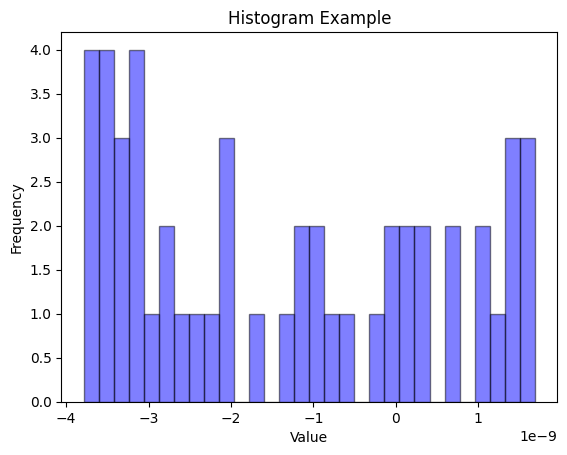

In [28]:
from matplotlib import pyplot as plt


plt.hist(diff, bins=30, alpha=0.5, color='blue', edgecolor='black')

# Adding titles and labels
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Showing the plot
plt.show()